# COMPUTER ASSIGNMENT 04


## U-net for image segmentation

You should create a folder 'data/' in the current folder.

Then download train, train_mask, test dataset from the above link and extract them to 'data/'.

Or you can download the whole dataset from [Kaggle website](https://www.kaggle.com/c/carvana-image-masking-challenge/data).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
import glob
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Define following layers to be used later
- **Conv2d + BatchNorm2d + ReLu** as **single_conv layer** ,
- **down layer**: use **Maxpool2d** to downsample by a factor of 2
- **up layer**: takes two inputs of different dimensions. First use **nn.Upsample** to upsample the smaller input to be the same size as the larger, then **concatenate** the two along the channel dimension
-  **outconv layer**: **Conv2d** followed by **sigmoid activation** to generate probability for each pixel

You can check out the documentation in this link to understand how to use the methods called in the provided template:

 https://pytorch.org/docs/stable/nn.html


In [3]:
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        
        self.conv = nn.Conv2d(in_channels = in_ch, out_channels = out_ch, padding=(1,1), kernel_size=3)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # define forward operation using the layers we have defined
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        return x

# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool2d(2,2)  # use nn.MaxPool2d( )
        
    def forward(self, x):
        x = self.down(x)
        return x


class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()       
        self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear')  # use nn.Upsample() with mode bilinear

    def forward(self, x1, x2): 
        x1 = self.up(x1)
        
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x2, x1), 1)
        #doubt: dimension =1 for channel?
        
        return x

# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch,kernel_size=(3,3))

    def forward(self, x):
        x = self.conv(x)
        # Apply sigmoid activation: torch.sigmoid()
        x = torch.sigmoid(x)
        return x
    

In [4]:
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv1 = single_conv(n_channels_in, 16)
        self.downSampled1 = down()
        self.conv2 = single_conv(16, 32)
        self.downSampled2 = down()
        self.conv3 = single_conv(32,32)
        self.upSampled1 = up()
        self.conv4 = single_conv(64, 16)
        self.upSampled2 = up()
        self.conv5 = single_conv(32, 16)
        self.conv6 = outconv(16, n_channels_out)

    def forward(self, x):
        # Define forward pass
        x = self.conv1(x)
        cat1 = x
        x = self.downSampled1(x)
        x = self.conv2(x)
        cat2 = x
        
        x = self.downSampled2(x)
        x = self.conv3(x)
        
        x = self.upSampled1(cat2, x)
        x = self.conv4(x)
        
        x = self.upSampled2(cat1, x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        return x
        
        
        
        
        
        
        

### Define evaulation function:
Dice coefficient is defined as 
![dice.png](dice.png)
For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate intersection of A and B as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

In order to quantify the area of A union B, some researchers use the simple sum whereas other researchers prefer to use the squared sum for this calculation. You can use either way.



In [5]:
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0
        A = prediction.contiguous().view(-1)
        B = target.contiguous().view(-1)
        self.inter = torch.dot(A, B)
        self.union = A.sum() + B.sum() + eps
        
        # Calculate DICE 
        d = self.inter/self.union
        return d


def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    for i, (a,b) in enumerate(zip(prediction, target)):
        s = s + DiceCoeff().forward(a, b)
    s = s / (i + 1)
    return s


### Load images and masks

Load training imagse, normalize and resize them into smaller size so that you can perform training using a CPU. Split them into training and validation. Validation percent of 0.05 means 5% of training dataset is used as validation. In order to avoid repeated data preprocessing, use the pickle tool to save the processed data.



In [6]:
# try to split the whole train dataset into train and validation, and match the train image path with the 
# corresponding label path
def split_train_val(image_paths, mask_paths, train_size):
    img_paths_dic = {}
    mask_paths_dic = {}
    len_data = len(image_paths)
    print('total len:', len_data)
    for i in range(len(image_paths)):
        img_paths_dic[os.path.basename(image_paths[i])[:-4]] = image_paths[i]

    for i in range(len(mask_paths)):
        mask_paths_dic[os.path.basename(mask_paths[i])[:-9]] = mask_paths[i]
        
    img_mask_list = []
    for key in img_paths_dic:
        img_mask_list.append((img_paths_dic[key], mask_paths_dic[key]))
        
    train_img_mask_paths = img_mask_list[:int(len_data*train_size)] 
    val_img_mask_paths = img_mask_list[int(len_data*train_size):]
    return train_img_mask_paths, val_img_mask_paths

# read in the image and label pair, and then resize them from 1280*1918 to 80*100 by consideration of 
# your computer memory limitation
def preprocess_image(image_mask_paths):
    img_mask_list = []
    new_h, new_w = 80, 100
    
    for i in tqdm(range(len(image_mask_paths))):
        # cv2 cannot read .gif files
        # Use Image.open() to open image and mask, then convert them to np arrays
        # For images use float32, mask use uint8
        # Normalize img to range (0,1)
        img = np.array(Image.open(image_mask_paths[i][0]), np.float32) / 255.0 
        mask = np.array(Image.open(image_mask_paths[i][1]), np.uint8)
        
        # Use cv2 to resize images to 80x100, use INTER_CUBIC interpolation
        img_resize = cv2.resize(img, dsize=(new_w, new_h), interpolation=cv2.INTER_CUBIC)
        mask_resize = np.uint8(cv2.resize(mask, dsize=(new_w, new_h), interpolation=cv2.INTER_CUBIC))
        
        img_mask_list.append((img_resize, mask_resize))
    return img_mask_list

# save the data into pickle file and you can just reload this file, which can help you avoid reading the image
# file again in the future, since reading in image file from hard drive would take quite a long time
def pickle_store(file_name,save_data):
    fileObj = open(file_name,'wb')
    pickle.dump(save_data,fileObj)
    fileObj.close()

In [7]:
# get all the image and mask path and number of images
image_paths = glob.glob("data/train/*.jpg")
mask_paths = glob.glob("data/train_masks/*.gif")

# split these path using a certain percentage
train_size = 0.95
print('original image shape: {}'.format(np.array(Image.open(image_paths[0])).shape))
print('orginal mask shape: {}'.format(np.array(Image.open(mask_paths[0])).shape))

train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths, mask_paths, train_size)

print('train len: {}, val len: {}'.format(len(train_img_mask_paths),len(val_img_mask_paths)))

original image shape: (1280, 1918, 3)
orginal mask shape: (1280, 1918)
total len: 5088
train len: 4833, val len: 255


In [8]:
## This part preprocess the images and save them to pickle files.
## If the pickle file already exists, this part will not run
## IMPORTANT: If you made any change to the prepreprocess function, 
## you need to delete the pickle files before you rerun this part
train_img_masks_save_path = './data/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    train_img_masks = preprocess_image(train_img_mask_paths)
    pickle_store(train_img_masks_save_path,train_img_masks)
print('train len: {}'.format(len(train_img_masks)))

train len: 4833


In [9]:
val_img_masks_save_path = './data/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    val_img_masks = preprocess_image(val_img_mask_paths)
    pickle_store(val_img_masks_save_path,val_img_masks)
print('val len: {}'.format(len(val_img_masks)))

val len: 255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


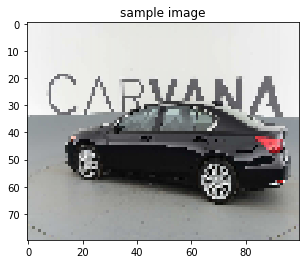

In [10]:
#### Let us display some of the images to make sure the data loading and processing is correct.
### the original size of the image is: 1280*1918, but we resize the image to 80*100 for 
### training the segmentation network
img_num = 5
plt.imshow(train_img_masks[img_num][0])
plt.title("sample image")
plt.show()

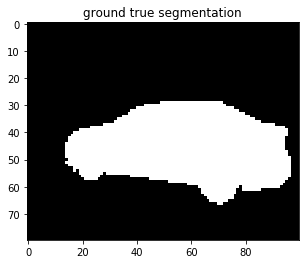

In [11]:
plt.imshow(train_img_masks[img_num][1], cmap='gray')
plt.title("ground true segmentation")
plt.show()

### Create datasets in the format that you can later use Torch  "DataLoader" during training and define  data augmentation 

In [12]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [13]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]
        
        image = np.transpose(image, axes=[2, 0, 1]) # C, H, W
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))

###  Start training your network

In [14]:

def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)
        # Feed the image to network to get predicted mask
        mask_pred = net(img)
        mask_pred = nn.functional.interpolate(mask_pred, size=(80,100), mode='bilinear')
        
        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        mask_pred[mask_pred>0.5] = 1
        mask_pred[mask_pred<=0.5] = 0
       
        tot += dice_coeff(mask_pred, true_mask)
        # Return average dice_coeff()
    return tot / (i + 1)

In [15]:
net = UNet(3,1)
net = net.to(device)
# run net.to(device) if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (downSampled1): down(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (downSampled2): down(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (upSampled1): up(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (conv4): single_conv(
    (conv): Conv2d(6

In [16]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 10          # e.g. 10, or more until dice converge  #doubt: how many epochs?
batch_size = 16    # e.g. 16
lr =  0.01           # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = './model/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), momentum=0.9, weight_decay=0.0005, lr=lr)

criterion = nn.BCELoss()

for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    for i, b in enumerate(train_loader):
        # Get images and masks from each batch
        
        imgs = b['img'].to(device)
        #imgs = np.moveaxis(imgs, 2, 0)
        true_masks = b['label'].to(device)

        # Feed your images into the network
        
        masks_pred = net(imgs)
        masks_pred = nn.functional.interpolate(masks_pred, size=(80,100), mode='bilinear') #doubt:?
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        masks_probs_flat = masks_pred.view(-1)
        true_masks_flat = true_masks.view(-1)
        
        loss = criterion(masks_probs_flat,true_masks_flat)
        epoch_loss += loss.item()
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    
    val_dice = eval_net(net, val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

Starting epoch 1/10.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.0000 --- loss: 0.653834
0.0662 --- loss: 0.195259
0.1324 --- loss: 0.111550
0.1986 --- loss: 0.088009
0.2648 --- loss: 0.083896
0.3311 --- loss: 0.072536
0.3973 --- loss: 0.067996
0.4635 --- loss: 0.070482
0.5297 --- loss: 0.065656
0.5959 --- loss: 0.065329
0.6621 --- loss: 0.074165
0.7283 --- loss: 0.069679
0.7945 --- loss: 0.065857
0.8607 --- loss: 0.056668
0.9270 --- loss: 0.058465
0.9932 --- loss: 0.061648
Epoch finished ! Loss: 0.09762793190974668
Validation Dice Coeff: tensor([0.4589], grad_fn=<DivBackward0>)
Checkpoint 1 saved !
Starting epoch 2/10.
0.0000 --- loss: 0.054146
0.0662 --- loss: 0.056272
0.1324 --- loss: 0.053210
0.1986 --- loss: 0.059496
0.2648 --- loss: 0.055651
0.3311 --- loss: 0.058296
0.3973 --- loss: 0.054810
0.4635 --- loss: 0.053694
0.5297 --- loss: 0.057602
0.5959 --- loss: 0.054964
0.6621 --- loss: 0.055163
0.7283 --- loss: 0.052317
0.7945 --- loss: 0.056709
0.8607 --- loss: 0.056254
0.9270 --- loss: 0.052618
0.9932 --- loss: 0.051100
Epoch finished ! Lo

### load one image from testing dataset and plot output mask

In [27]:
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()
    
    # convert from Height*Width*Channel TO Channel*Height*Width
    full_img = np.moveaxis(full_img, -1, 0)
    
    # convert numpy array to torch tensor, normalize to range (0,1)
    X_img = torch.from_numpy(full_img)/255.0
    X_img = X_img.unsqueeze(0)
    
    with torch.no_grad():
        
        X_img = X_img.to(device)
        output_img = net(X_img)
        out_probs = output_img.squeeze(0).squeeze(0)
        
        out_mask_np = (out_probs > out_threshold).float()
        if torch.cuda.is_available():
            out_mask_np = out_mask_np.cpu()
        out_mask_np = out_mask_np.numpy().astype('uint8')
        
    return out_mask_np


In [28]:
test_img_paths = glob.glob("data/test/*.jpg")
test_img = np.array(Image.open(test_img_paths[0]))

orig_shape = test_img.shape

# Resize image to (80,100)
img_resize = cv2.resize(test_img,(80, 100), cv2.INTER_CUBIC )

mask = predict_img(net, img_resize)
# Rescale the mask back to original image size
mask =  cv2.resize(np.array(mask), (orig_shape[1], orig_shape[0]), cv2.INTER_CUBIC )


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [29]:
## Extract the car from the image using the predicted mask
img_seg = test_img.copy()
for i in range(3):
    img_seg[:, :, i] =  test_img[:, :, i] * mask

### Plot original image and mask image

Text(0.5, 1.0, 'Car')

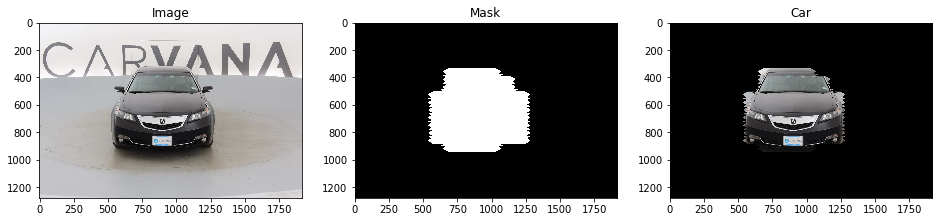

In [30]:
# Plot original images and masks and segmented part
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow(img_seg)
plt.title('Car')

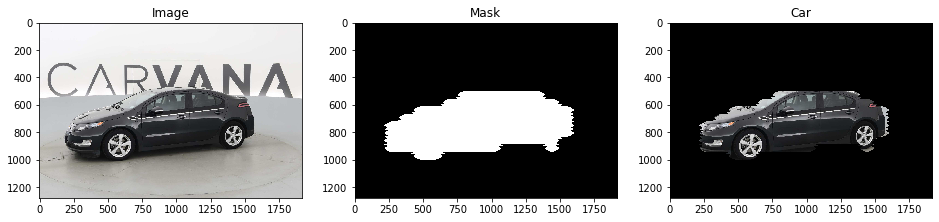

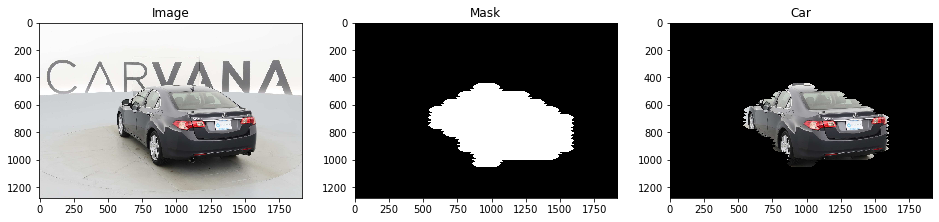

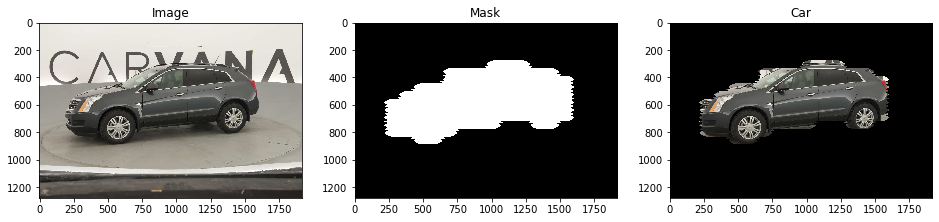

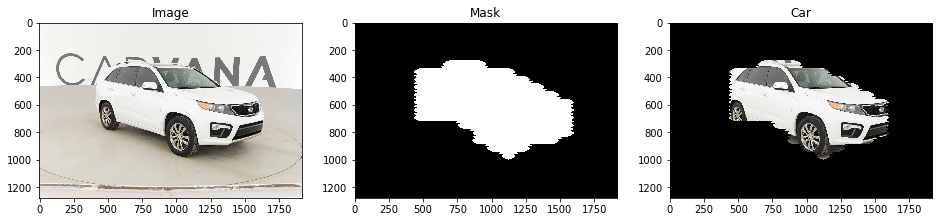

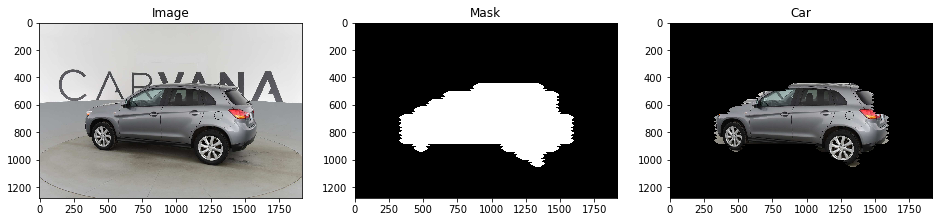

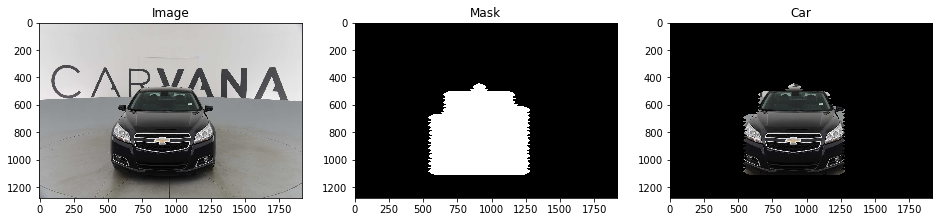

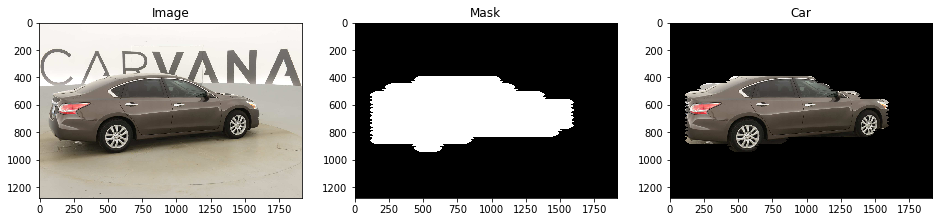

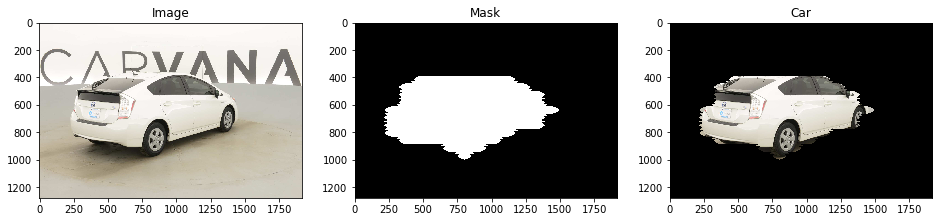

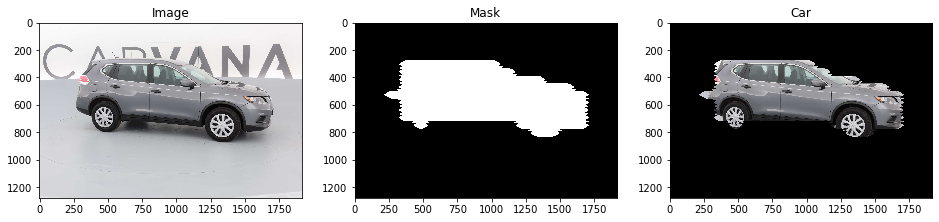

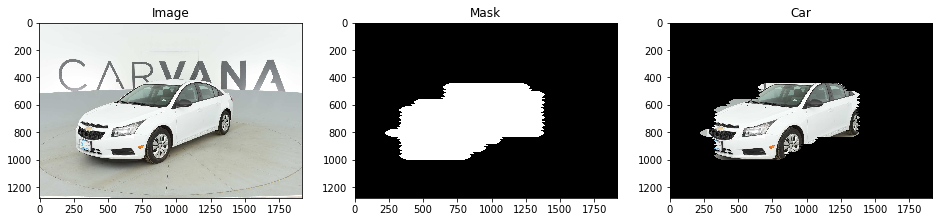

In [26]:
# Display ten more of test samples
length = len(test_img_paths)
count = 0
while(count < 10):
    k = np.random.randint(0, length)
    test_img = np.array(Image.open(test_img_paths[k]))

    orig_shape = test_img.shape

    # Resize image to (80,100)
    img_resize = cv2.resize(test_img,(80, 100), cv2.INTER_CUBIC )

    
    # Predict the mask
    mask = predict_img(net, img_resize)
    # Rescale the mask back to original image size
    mask =  cv2.resize(np.array(mask), (orig_shape[1], orig_shape[0]), cv2.INTER_CUBIC )
    temp = test_img.copy()
    for i in range(3):
        temp[:, :, i] =  test_img[:, :, i] * mask
    plt.figure(figsize = (16,48))
    plt.subplot(1,3,1)
    plt.imshow(test_img)
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(temp)
    plt.title('Car')
    
    count += 1